In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from typing import Tuple
import datetime as dt
import seaborn as sns
import itertools

from sklearn.metrics import classification_report,confusion_matrix,\
    precision_score,recall_score,f1_score,precision_recall_curve,\
    roc_curve,roc_auc_score,auc

In [2]:
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)

In [3]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['f1'] = f1_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['f1'] = f1_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['f1'] = f1_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'f1','roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (14, 6))
    plt.rcParams['font.size'] = 12
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: ht	Хоменко Ольга Володимирівнаtp://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, size = 12)
    plt.yticks(tick_marks, classes, size = 12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Data exploration and preprocessing

In [5]:
dataset = pd.read_csv('~/MyPrograms/IAD/lab_2/dataset_Malicious_and_Benign_Websites.csv')
dataset.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [6]:
# Fix 'None' to np.nan
dataset.replace({"None":np.nan},inplace=True)

In [7]:
dataset.shape

(1781, 21)

([<matplotlib.patches.Wedge at 0x7ff0fd4664f0>,
 [Text(1.0211172921099605, 0.40904703366975004, 'Malicious'),
  Text(-1.0211173112588332, -0.4090469858677992, 'Benign')],
 [Text(0.5569730684236148, 0.22311656381986364, '12.1%'),
  Text(-0.5569730788684544, -0.2231165377460723, '87.9%')])

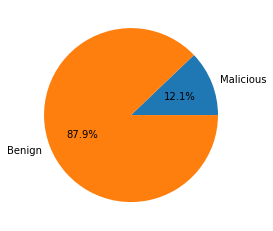

In [8]:
plt.pie([dataset["Type"].sum(),
         dataset["Type"].shape[0]-dataset["Type"].sum()],labels = ["Malicious","Benign"],autopct='%1.1f%%')

In [9]:
dataset.columns

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [10]:
pd.set_option('display.max_columns',None)
dataset.describe(include="all")

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781,1781.000000,1781.000000,1774,1605,969.000000,1475,1419,1654,1642,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
unique,1781,NaN,NaN,8,238,NaN,48,181,890,593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M0_109,NaN,NaN,UTF-8,Apache,NaN,US,CA,17/09/2008 0:00,2/09/2016 0:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,676,386,NaN,1103,372,62,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,56.961258,11.111735,NaN,NaN,11726.927761,NaN,NaN,NaN,NaN,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,NaN,27.555586,4.549896,NaN,NaN,36391.809051,NaN,NaN,NaN,NaN,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,NaN,16.000000,5.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,NaN,39.000000,8.000000,NaN,NaN,324.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,NaN,49.000000,10.000000,NaN,NaN,1853.000000,NaN,NaN,NaN,NaN,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,NaN,68.000000,13.000000,NaN,NaN,11323.000000,NaN,NaN,NaN,NaN,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000


In [11]:
# drop URLs because they are unique
dataset = dataset.drop("URL",axis=1)

In [12]:
dataset.dtypes

URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

In [13]:
dataset.shape

(1781, 20)

In [14]:
dataset.isnull().sum()

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        7
SERVER                       176
CONTENT_LENGTH               812
WHOIS_COUNTRY                306
WHOIS_STATEPRO               362
WHOIS_REGDATE                127
WHOIS_UPDATED_DATE           139
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [15]:
# Getting years and month
dataset["WHOIS_UPDATED_YEAR"] = dataset["WHOIS_UPDATED_DATE"].str.split().str[0].str.split("/").str[2]
dataset["WHOIS_UPDATED_MONTH"] = dataset["WHOIS_UPDATED_DATE"].str.split().str[0].str.split("/").str[1]
dataset["WHOIS_REG_YEAR"] = dataset["WHOIS_REGDATE"].str.split().str[0].str.split("/").str[2]
dataset["WHOIS_REG_MONTH"] = dataset["WHOIS_REGDATE"].str.split().str[0].str.split("/").str[1]

dataset.drop("WHOIS_UPDATED_DATE",axis=1,inplace=True)
dataset.drop("WHOIS_REGDATE",axis=1,inplace=True)

In [16]:
dataset

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,WHOIS_UPDATED_YEAR,WHOIS_UPDATED_MONTH,WHOIS_REG_YEAR,WHOIS_REG_MONTH
0,16,7,iso-8859-1,nginx,263.0,NaN,NaN,7,0,2,700,9,10,1153,832,9,2.0,1,NaN,NaN,2015,10
1,16,6,UTF-8,Apache/2.4.10,15087.0,NaN,NaN,17,7,4,1230,17,19,1265,1230,17,0.0,0,NaN,NaN,NaN,NaN
2,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0.0,0,NaN,NaN,NaN,NaN
3,17,6,ISO-8859-1,nginx,162.0,US,AK,31,22,3,3812,39,37,18784,4380,39,8.0,0,2013,09,1997,10
4,17,6,UTF-8,NaN,124140.0,US,TX,57,2,5,4278,61,62,129889,4586,61,4.0,0,2017,04,1996,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,194,16,UTF-8,Apache,NaN,ES,Barcelona,0,0,0,0,0,3,186,0,0,0.0,1,2016,09,2008,09
1777,198,17,UTF-8,Apache,NaN,ES,Barcelona,0,0,0,0,0,2,124,0,0,0.0,1,2016,09,2008,09
1778,201,34,utf-8,Apache/2.2.16 (Debian),8904.0,US,FL,83,2,6,6631,87,89,132181,6945,87,4.0,0,2015,07,1999,02
1779,234,34,ISO-8859-1,cloudflare-nginx,NaN,US,CA,0,0,0,0,0,0,0,0,0,0.0,0,2016,12,1998,04


In [17]:
dataset["SERVER"].nunique(),dataset["CHARSET"].nunique(),dataset["WHOIS_COUNTRY"].nunique()

(238, 8, 48)

In [18]:
categorical_features = ["CHARSET","SERVER","WHOIS_COUNTRY","WHOIS_STATEPRO"]
continious_features = list(set(dataset.dtypes.keys())-set(categorical_features))
# continious_features.remove("Type")

In [19]:
benign_websites_count = dataset[dataset["Type"]==0].shape[0]
malicious_websites_count = dataset[dataset["Type"]==1].shape[0]
print(f"Benign websites: ",benign_websites_count)
print(f"Malicious websites: {malicious_websites_count}")
print(f"Benign websites ratio: {benign_websites_count/dataset.shape[0]}")
print(f"Malicious_dataset websites ratio: {malicious_websites_count/dataset.shape[0]}")

Benign websites:  1565
Malicious websites: 216
Benign websites ratio: 0.8787198203256598
Malicious_dataset websites ratio: 0.12128017967434025


In [20]:
# Unbalanced Dataset!

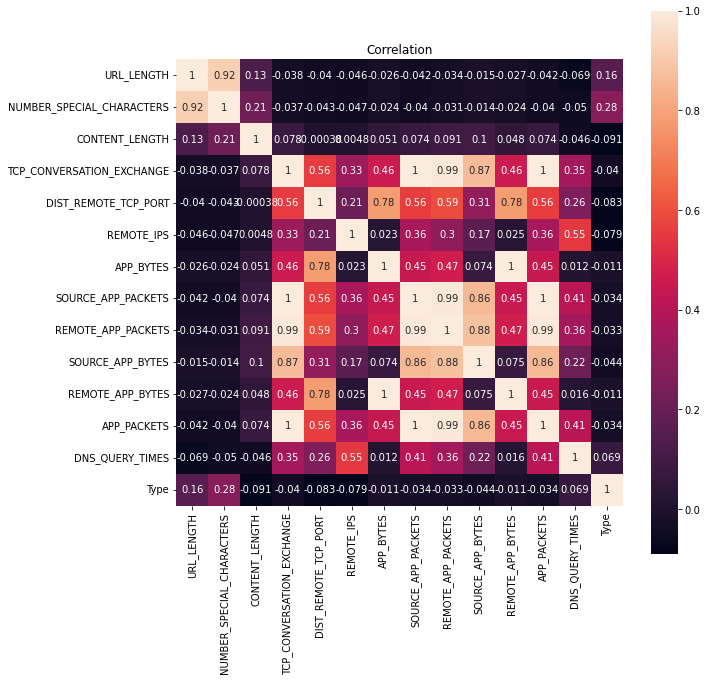

In [21]:
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(dataset.corr(),annot=True,square=True)
plt.title("Correlation");

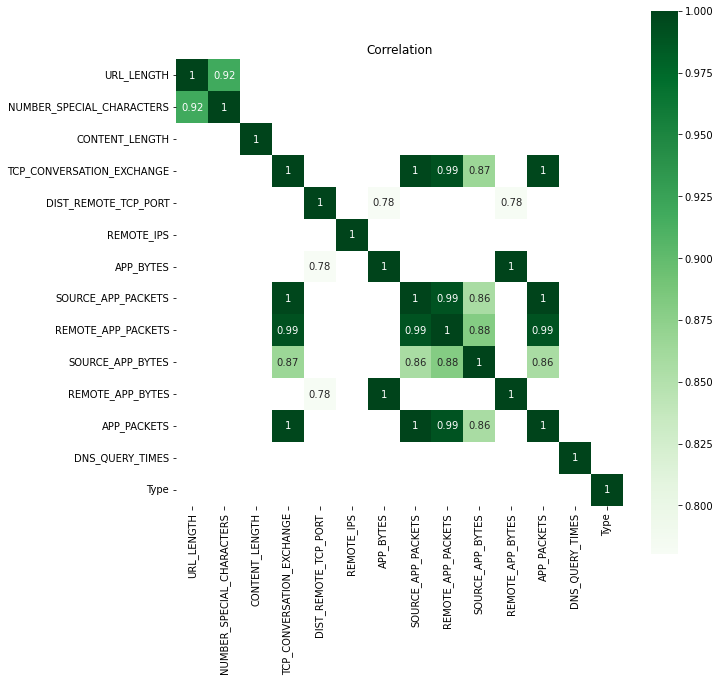

In [22]:
%matplotlib inline
corr = dataset.corr()
corr = corr[corr>.7]
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,square=True,cmap="Greens")
plt.title("Correlation");

In [23]:
top_correlated_features = list(dataset.corr()["Type"].abs().sort_values(ascending=False)[:7].keys())
top_correlated_features.remove("Type")

In [24]:
def remove_correlation(dataset:pd.DataFrame,
                       threshold:float) -> Tuple[pd.DataFrame,set]:
    dataset = deepcopy(dataset)
    corr_features = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in corr_features):
                colname = corr_matrix.columns[i] # getting the name of column
                corr_features.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset,corr_features

In [25]:
dataset.columns

Index(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO',
       'TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS',
       'APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS',
       'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'APP_PACKETS',
       'DNS_QUERY_TIMES', 'Type', 'WHOIS_UPDATED_YEAR', 'WHOIS_UPDATED_MONTH',
       'WHOIS_REG_YEAR', 'WHOIS_REG_MONTH'],
      dtype='object')

In [26]:
dataset = dataset.drop(["TCP_CONVERSATION_EXCHANGE",
                                     "REMOTE_APP_BYTES",
                                     "REMOTE_APP_PACKETS","APP_PACKETS"],axis=1)

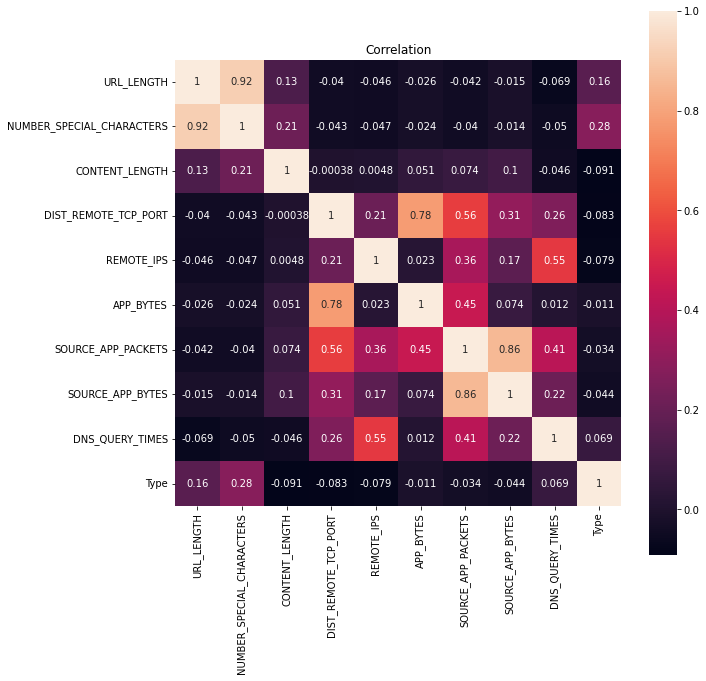

In [27]:
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(dataset.corr(),annot=True,square=True)
plt.title("Correlation");

In [28]:
categorical_features.append("Type")

# Models

In [29]:
necessary_features = categorical_features+top_correlated_features

In [30]:
X,y = dataset[necessary_features].drop("Type",axis=1),dataset["Type"]

In [31]:
y = np.array(y)

In [32]:
X.fillna(X.median(),inplace=True)

/tmp/ipykernel_120997/2551560147.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X.fillna(X.median(),inplace=True)


In [33]:
# scale
X[top_correlated_features] = (X[top_correlated_features]-X[top_correlated_features].mean())/X[top_correlated_features].std()

In [34]:
X = pd.get_dummies(X)

In [35]:
features_names = X.columns

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [37]:
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)

model2 = DecisionTreeClassifier(max_depth=15, max_features=250, max_leaf_nodes=100,
                                min_samples_leaf=12, min_samples_split=6, random_state=0)
model2.fit(X_train, y_train)

model3 = DecisionTreeClassifier(max_depth=5, max_features=100, max_leaf_nodes=200,
                                min_samples_leaf=8, min_samples_split=4, random_state=0)
model3.fit(X_train, y_train)

print(f'Decision tree has {model.tree_.node_count} nodes with maximum depth {model.tree_.max_depth}.')
print(f'Second Decision tree has {model2.tree_.node_count} nodes with maximum depth {model2.tree_.max_depth}.')
print(f'Third Decision tree has {model3.tree_.node_count} nodes with maximum depth {model3.tree_.max_depth}.')

Decision tree has 151 nodes with maximum depth 23.
Second Decision tree has 65 nodes with maximum depth 8.
Third Decision tree has 49 nodes with maximum depth 5.


In [38]:
sum(y_train)/y_train.shape

array([0.12921348])

In [39]:
X_train.shape,y_train.shape

((1246, 481), (1246,))

In [40]:
# Make probability predictions
train_probs = model.predict_proba(X_train)[:, 1]
probs = model.predict_proba(X_test)[:, 1]

train_predictions = model.predict(X_train)
predictions = model.predict(X_test)

In [41]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 1.0
Test  ROC AUC Score: 0.9025568181818182
Baseline ROC AUC: 0.5


Recall Baseline: 1.0 Test: 0.84 Train: 1.0
Precision Baseline: 0.1 Test: 0.75 Train: 1.0
F1 Baseline: 0.19 Test: 0.79 Train: 1.0
Roc Baseline: 0.5 Test: 0.9 Train: 1.0


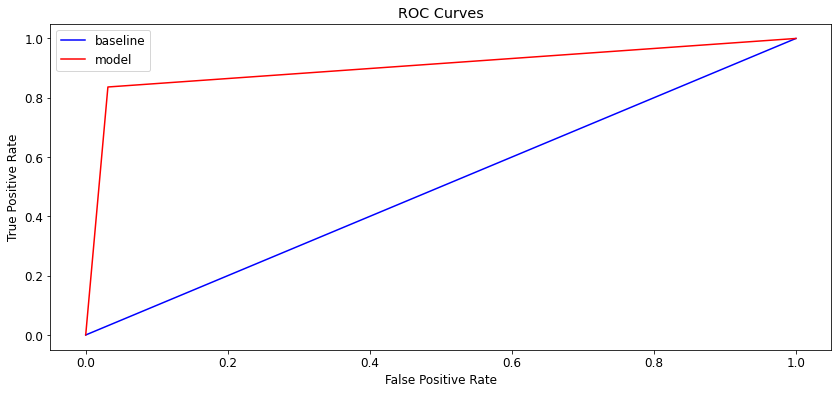

In [42]:
evaluate_model(predictions, probs, train_predictions, train_probs)

No handles with labels found to put in legend.


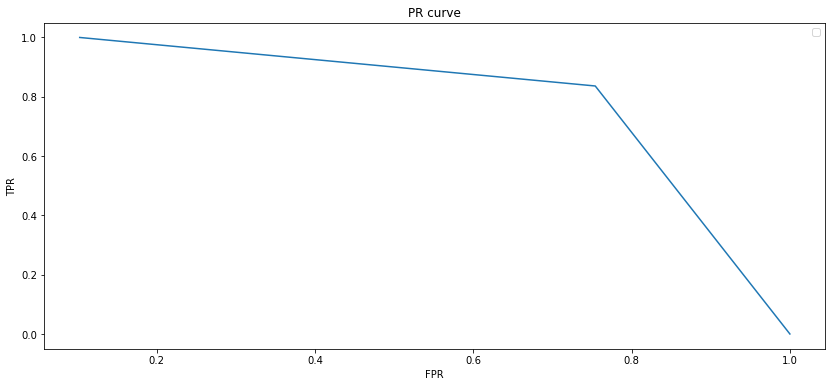

In [43]:
%matplotlib inline
prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[465  15]
 [  9  46]]


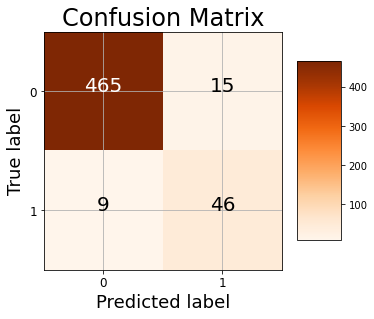

In [44]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [45]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       480
           1       0.75      0.84      0.79        55

    accuracy                           0.96       535
   macro avg       0.87      0.90      0.88       535
weighted avg       0.96      0.96      0.96       535



In [46]:
# Make probability predictions
train_probs = model2.predict_proba(X_train)[:, 1]
probs = model2.predict_proba(X_test)[:, 1]

train_predictions = model2.predict(X_train)
predictions = model2.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 0.9765177319174514
Test  ROC AUC Score: 0.9653409090909091
Baseline ROC AUC: 0.5


No handles with labels found to put in legend.


Recall Baseline: 1.0 Test: 0.62 Train: 0.62
Precision Baseline: 0.1 Test: 0.87 Train: 0.93
F1 Baseline: 0.19 Test: 0.72 Train: 0.75
Roc Baseline: 0.5 Test: 0.97 Train: 0.98


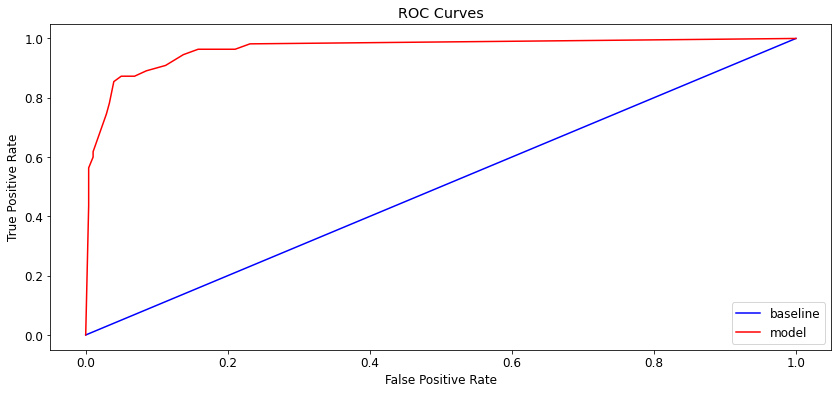

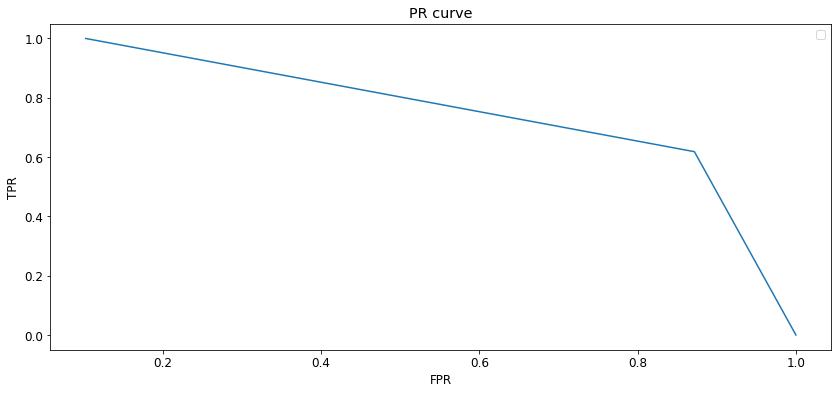

In [47]:
%matplotlib inline
evaluate_model(predictions, probs, train_predictions, train_probs)

prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[475   5]
 [ 21  34]]


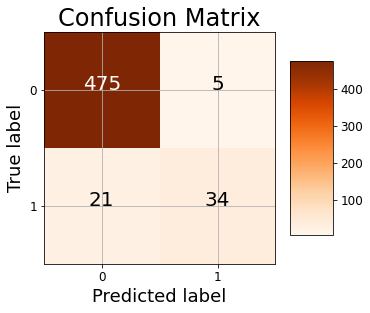

In [48]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [49]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       480
           1       0.87      0.62      0.72        55

    accuracy                           0.95       535
   macro avg       0.91      0.80      0.85       535
weighted avg       0.95      0.95      0.95       535



In [50]:
# Make probability predictions
train_probs = model3.predict_proba(X_train)[:, 1]
probs = model3.predict_proba(X_test)[:, 1]

train_predictions = model3.predict(X_train)
predictions = model3.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 0.9556000801442597
Test  ROC AUC Score: 0.9585795454545456
Baseline ROC AUC: 0.5


No handles with labels found to put in legend.


Recall Baseline: 1.0 Test: 0.73 Train: 0.68
Precision Baseline: 0.1 Test: 0.65 Train: 0.76
F1 Baseline: 0.19 Test: 0.68 Train: 0.72
Roc Baseline: 0.5 Test: 0.96 Train: 0.96


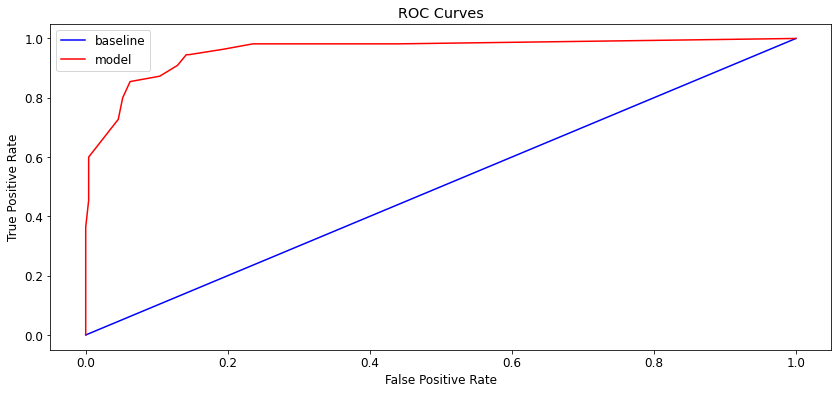

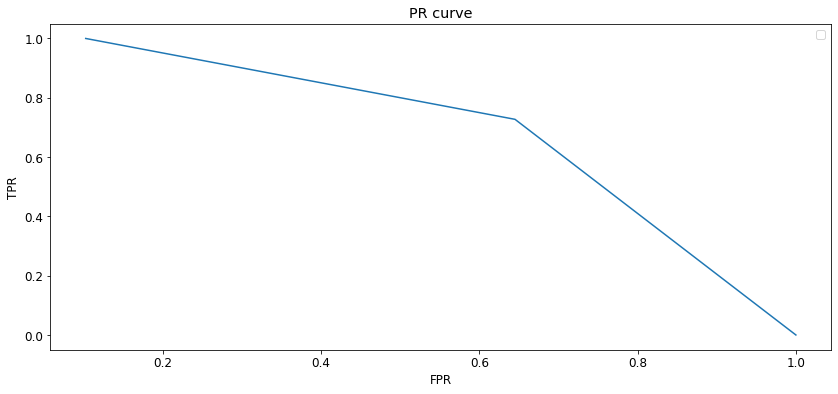

In [51]:
%matplotlib inline
evaluate_model(predictions, probs, train_predictions, train_probs)

prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[458  22]
 [ 15  40]]


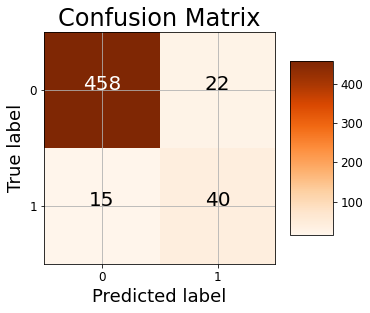

In [52]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [53]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       480
           1       0.65      0.73      0.68        55

    accuracy                           0.93       535
   macro avg       0.81      0.84      0.82       535
weighted avg       0.94      0.93      0.93       535



In [54]:
max_depth = [3,5,10,13,15]
max_features = [50,100,200,300,400]
min_samples_split = [4,5,6,7,8]
min_samples_leaf = [4,6,8,10,12]
max_leaf_nodes = [100,200,300,400,500]

parameters = {'max_depth': max_depth, 'max_features': max_features, 'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf, 'max_leaf_nodes': max_leaf_nodes}

In [55]:
gridSer = GridSearchCV(model, parameters) 
gridSer.fit(X_train, y_train)

best_estimator = gridSer.best_estimator_
print(gridSer.best_score_)
best_estimator

0.9446232931726908


DecisionTreeClassifier(max_depth=13, max_features=400, max_leaf_nodes=100,
                       min_samples_leaf=4, min_samples_split=4, random_state=0)

Confusion matrix, without normalization
[[468  12]
 [ 10  45]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       480
           1       0.79      0.82      0.80        55

    accuracy                           0.96       535
   macro avg       0.88      0.90      0.89       535
weighted avg       0.96      0.96      0.96       535



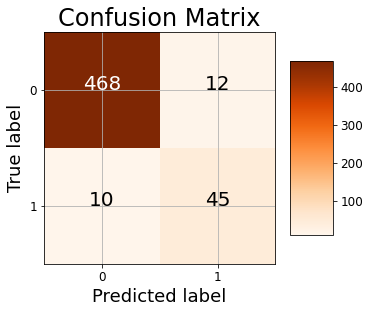

In [56]:
best_estimator.fit(X_train, y_train)
predictions = best_estimator.predict(X_test)

cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

print(classification_report(y_test, predictions))

# Second Dataset

In [57]:
np.random.seed(0)
X = np.random.randn(300, 2)
y = np.logical_xor(X[:, 0] > 0 , X[:, 1] > 0)

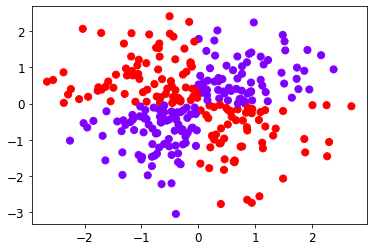

In [58]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [60]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

model2 = DecisionTreeClassifier(max_depth = 3, random_state=1)
model2.fit(X_train, y_train)

model3 = DecisionTreeClassifier(min_samples_split = 0.3, random_state=1)
model3.fit(X_train, y_train)

model4 = DecisionTreeClassifier(min_samples_leaf = 8, random_state=1)
model4.fit(X_train, y_train)

model5 = DecisionTreeClassifier(max_leaf_nodes = 7, random_state=1)
model5.fit(X_train, y_train)

model6 = DecisionTreeClassifier(max_features = 1, random_state=1)
model6.fit(X_train, y_train)

print(f'Decision tree has {model.tree_.node_count} nodes with maximum depth {model.tree_.max_depth}.')
print(f'Second Decision tree has {model2.tree_.node_count} nodes with maximum depth {model2.tree_.max_depth}.')
print(f'Third Decision tree has {model3.tree_.node_count} nodes with maximum depth {model3.tree_.max_depth}.')
print(f'Fourth Decision tree has {model4.tree_.node_count} nodes with maximum depth {model4.tree_.max_depth}.')
print(f'Fifth Decision tree has {model5.tree_.node_count} nodes with maximum depth {model5.tree_.max_depth}.')
print(f'Sixth Decision tree has {model6.tree_.node_count} nodes with maximum depth {model6.tree_.max_depth}.')

Decision tree has 19 nodes with maximum depth 5.
Second Decision tree has 11 nodes with maximum depth 3.
Third Decision tree has 11 nodes with maximum depth 4.
Fourth Decision tree has 15 nodes with maximum depth 5.
Fifth Decision tree has 13 nodes with maximum depth 4.
Sixth Decision tree has 33 nodes with maximum depth 9.


In [61]:
X_train.shape,y_train.shape

((210, 2), (210,))

/tmp/ipykernel_120997/2057100810.py:24: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/tmp/ipykernel_120997/2057100810.py:24: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/tmp/ipykernel_120997/2057100810.py:24: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/tmp/ipykernel_120997/2057100810.py:24: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/tmp/ipykernel_120997/2057100810.py:24: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/tmp/ipykernel_120997/2057100810.py:24: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


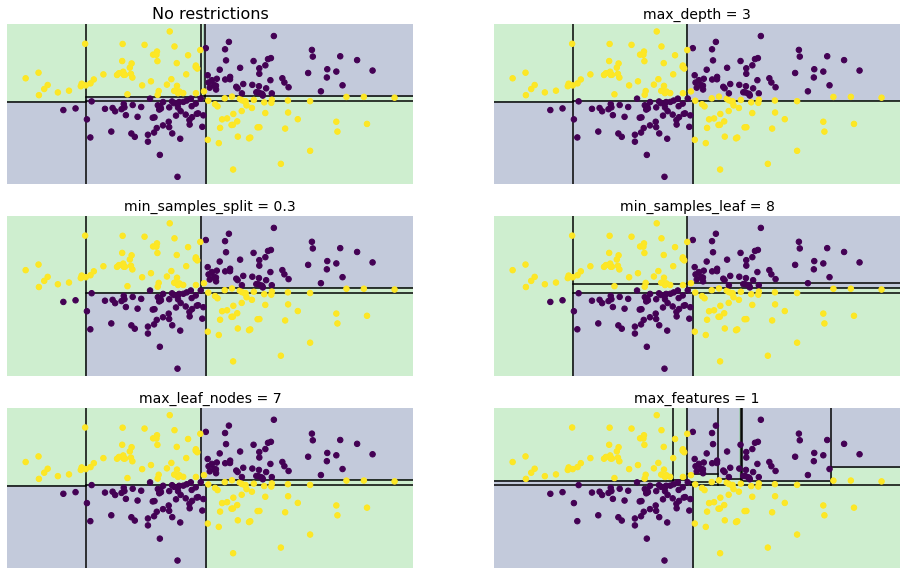

In [62]:
plt.figure(num=1, figsize=(16, 10))
plt.subplot(321)
visualize_tree(model, X_train, y_train)
plt.title("No restrictions", fontsize=16)
plt.subplot(322)
visualize_tree(model2, X_train, y_train)
plt.title("max_depth = {}".format(model2.max_depth), fontsize=14)

plt.subplot(323)
visualize_tree(model3, X_train, y_train)
plt.title("min_samples_split = {}".format(model3.min_samples_split), fontsize=14)
plt.subplot(324)
visualize_tree(model4, X_train, y_train)
plt.title("min_samples_leaf = {}".format(model4.min_samples_leaf), fontsize=14)

plt.subplot(325)
visualize_tree(model5, X_train, y_train)
plt.title("max_leaf_nodes = {}".format(model5.max_leaf_nodes), fontsize=14)
plt.subplot(326)
visualize_tree(model6, X_train, y_train)
plt.title("max_features = {}".format(model6.max_features), fontsize=14)

plt.show()

In [63]:
# Make probability predictions
train_probs = model.predict_proba(X_train)[:, 1]
probs = model.predict_proba(X_test)[:, 1]

train_predictions = model.predict(X_train)
predictions = model.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 1.0
Test  ROC AUC Score: 1.0
Baseline ROC AUC: 0.5


No handles with labels found to put in legend.


Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.49 Test: 1.0 Train: 1.0
F1 Baseline: 0.66 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


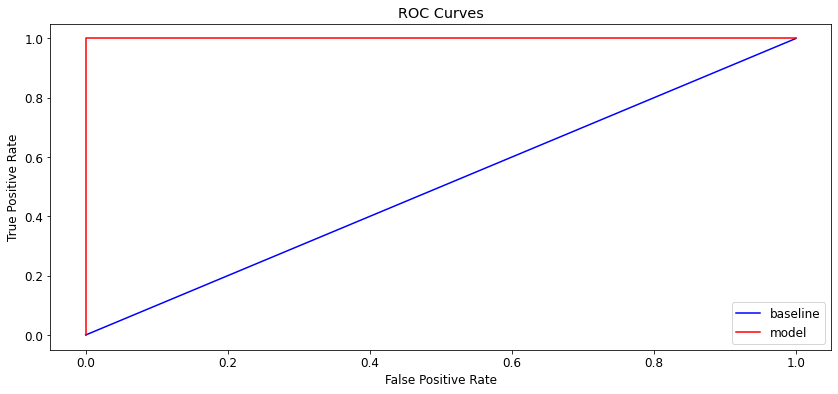

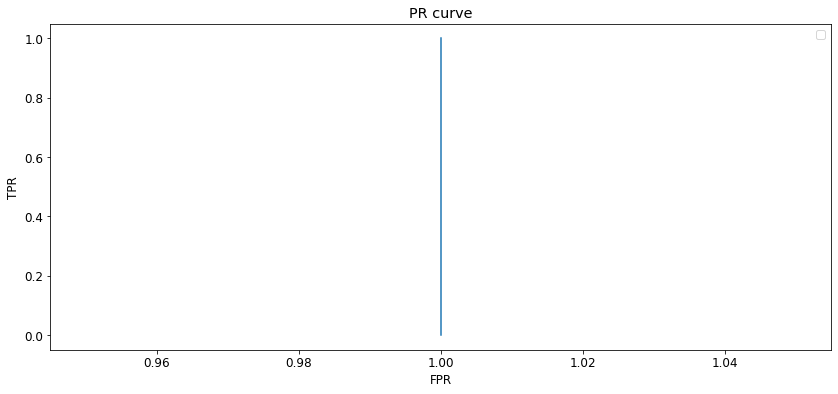

In [64]:
%matplotlib inline
evaluate_model(predictions, probs, train_predictions, train_probs)

prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[46  0]
 [ 0 44]]


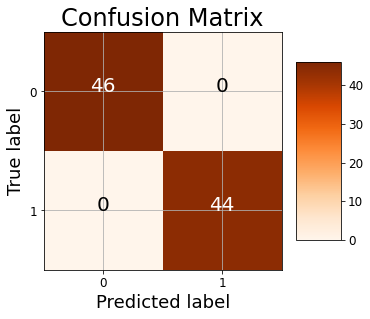

In [65]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [66]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        46
        True       1.00      1.00      1.00        44

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [67]:
# Make probability predictions
train_probs = model2.predict_proba(X_train)[:, 1]
probs = model2.predict_proba(X_test)[:, 1]

train_predictions = model2.predict(X_train)
predictions = model2.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 0.9567693148688047
Test  ROC AUC Score: 0.9357707509881423
Baseline ROC AUC: 0.5


No handles with labels found to put in legend.


Recall Baseline: 1.0 Test: 0.86 Train: 0.86
Precision Baseline: 0.49 Test: 0.9 Train: 0.97
F1 Baseline: 0.66 Test: 0.88 Train: 0.91
Roc Baseline: 0.5 Test: 0.94 Train: 0.96


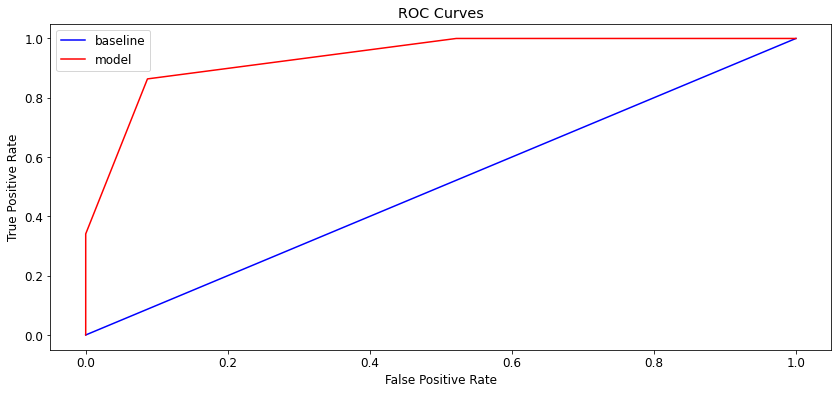

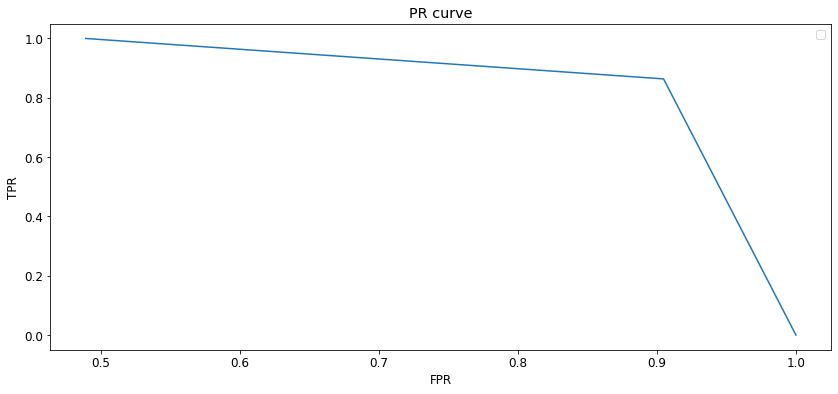

In [68]:
%matplotlib inline
evaluate_model(predictions, probs, train_predictions, train_probs)

prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[42  4]
 [ 6 38]]


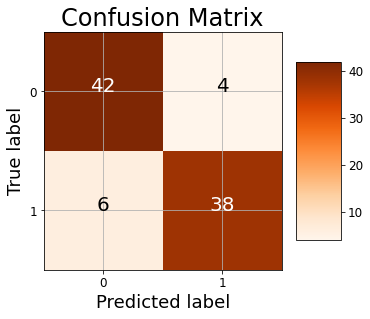

In [69]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [70]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.88      0.91      0.89        46
        True       0.90      0.86      0.88        44

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90



In [71]:
# Make probability predictions
train_probs = model3.predict_proba(X_train)[:, 1]
probs = model3.predict_proba(X_test)[:, 1]

train_predictions = model3.predict(X_train)
predictions = model3.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 0.9823250728862974
Test  ROC AUC Score: 0.9426877470355731
Baseline ROC AUC: 0.5


No handles with labels found to put in legend.


Recall Baseline: 1.0 Test: 0.93 Train: 0.99
Precision Baseline: 0.49 Test: 0.87 Train: 0.94
F1 Baseline: 0.66 Test: 0.9 Train: 0.97
Roc Baseline: 0.5 Test: 0.94 Train: 0.98


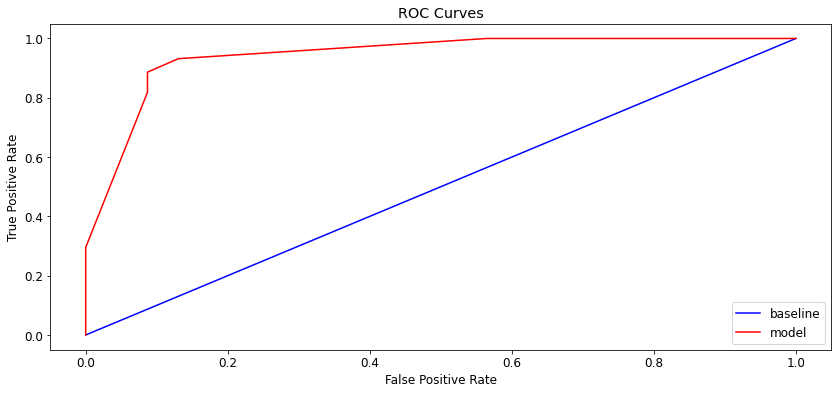

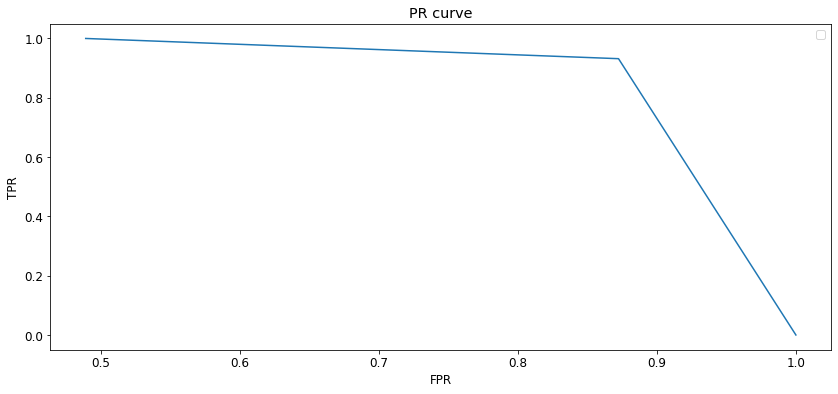

In [72]:
%matplotlib inline
evaluate_model(predictions, probs, train_predictions, train_probs)

prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[40  6]
 [ 3 41]]


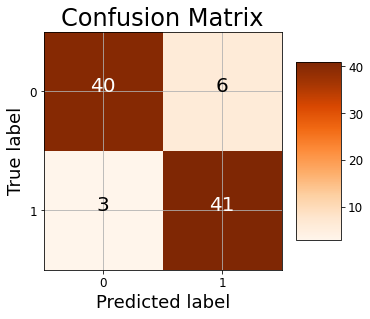

In [73]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [74]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.93      0.87      0.90        46
        True       0.87      0.93      0.90        44

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90



In [75]:
# Make probability predictions
train_probs = model4.predict_proba(X_train)[:, 1]
probs = model4.predict_proba(X_test)[:, 1]

train_predictions = model4.predict(X_train)
predictions = model4.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 0.9944879737609329
Test  ROC AUC Score: 0.9496047430830039
Baseline ROC AUC: 0.5


No handles with labels found to put in legend.


Recall Baseline: 1.0 Test: 0.93 Train: 0.99
Precision Baseline: 0.49 Test: 0.87 Train: 0.94
F1 Baseline: 0.66 Test: 0.9 Train: 0.97
Roc Baseline: 0.5 Test: 0.95 Train: 0.99


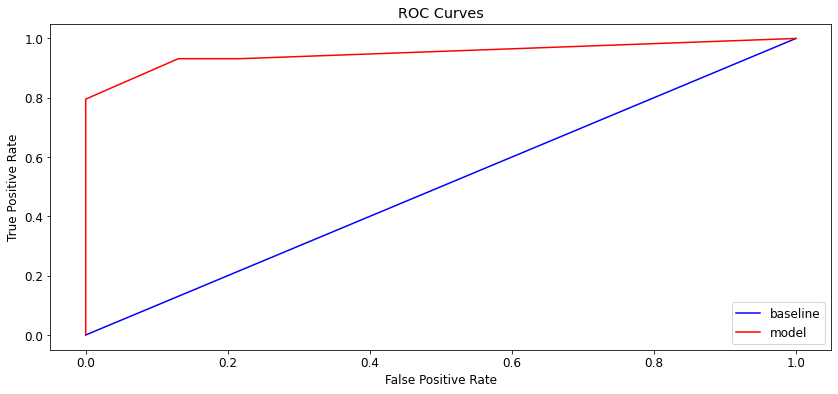

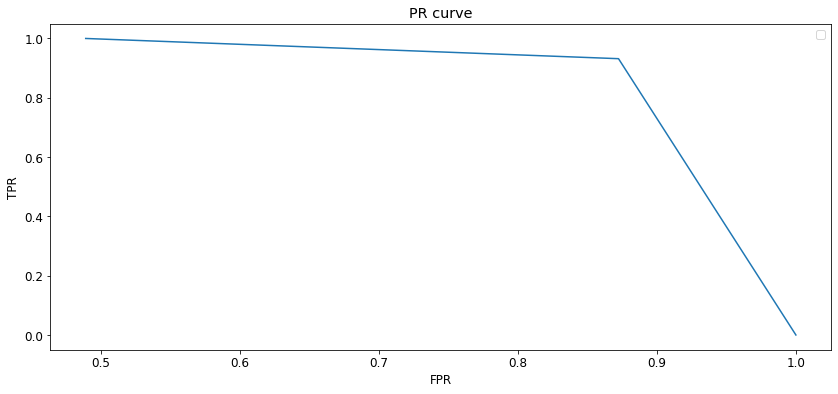

In [76]:
%matplotlib inline
evaluate_model(predictions, probs, train_predictions, train_probs)

prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[40  6]
 [ 3 41]]


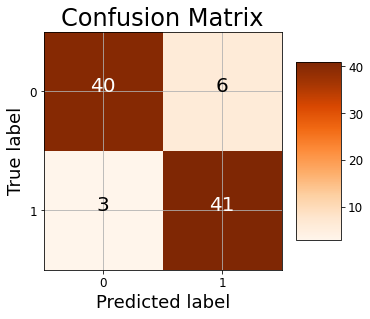

In [77]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [78]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.93      0.87      0.90        46
        True       0.87      0.93      0.90        44

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90



In [79]:
# Make probability predictions
train_probs = model5.predict_proba(X_train)[:, 1]
probs = model5.predict_proba(X_test)[:, 1]

train_predictions = model5.predict(X_train)
predictions = model5.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 0.9875182215743441
Test  ROC AUC Score: 0.950592885375494
Baseline ROC AUC: 0.5


No handles with labels found to put in legend.


Recall Baseline: 1.0 Test: 0.93 Train: 0.99
Precision Baseline: 0.49 Test: 0.91 Train: 0.96
F1 Baseline: 0.66 Test: 0.92 Train: 0.97
Roc Baseline: 0.5 Test: 0.95 Train: 0.99


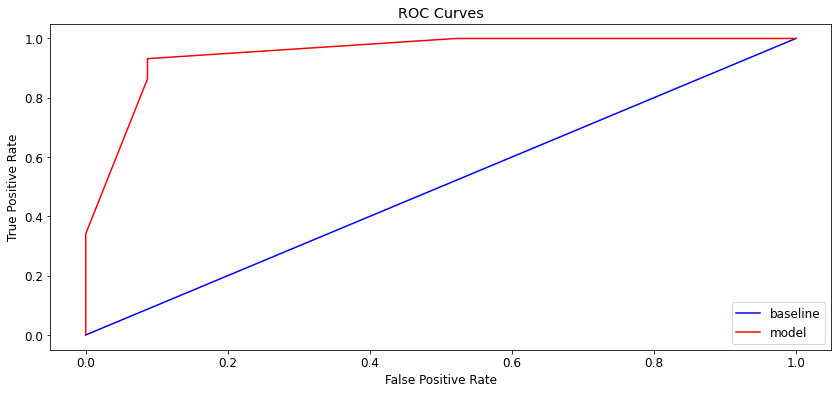

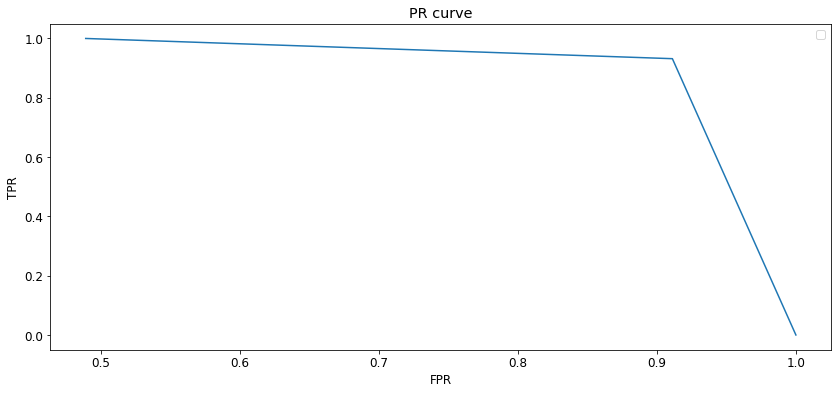

In [80]:
%matplotlib inline
evaluate_model(predictions, probs, train_predictions, train_probs)

prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[42  4]
 [ 3 41]]


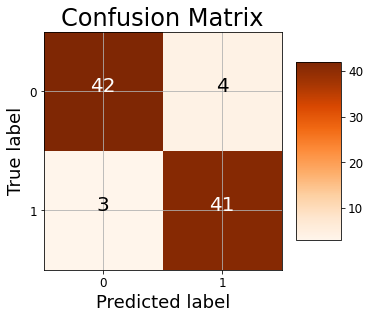

In [81]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [82]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.93      0.91      0.92        46
        True       0.91      0.93      0.92        44

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90



In [83]:
# Make probability predictions
train_probs = model6.predict_proba(X_train)[:, 1]
probs = model6.predict_proba(X_test)[:, 1]

train_predictions = model6.predict(X_train)
predictions = model6.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test  ROC AUC Score: {roc_auc_score(y_test, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Train ROC AUC Score: 1.0
Test  ROC AUC Score: 0.9441699604743083
Baseline ROC AUC: 0.5


No handles with labels found to put in legend.


Recall Baseline: 1.0 Test: 0.93 Train: 1.0
Precision Baseline: 0.49 Test: 0.95 Train: 1.0
F1 Baseline: 0.66 Test: 0.94 Train: 1.0
Roc Baseline: 0.5 Test: 0.94 Train: 1.0


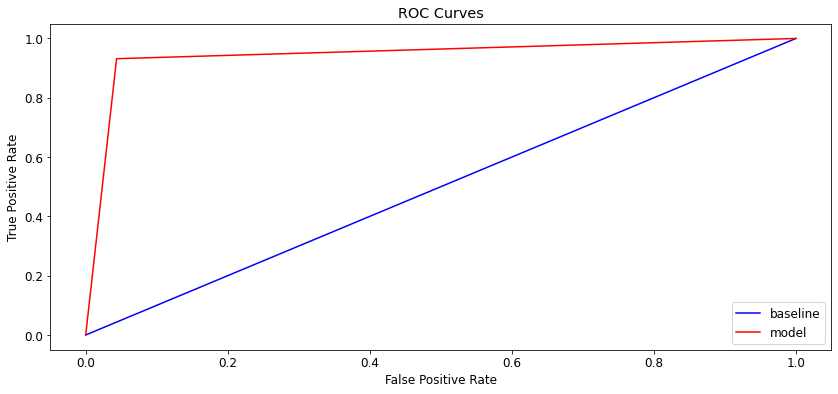

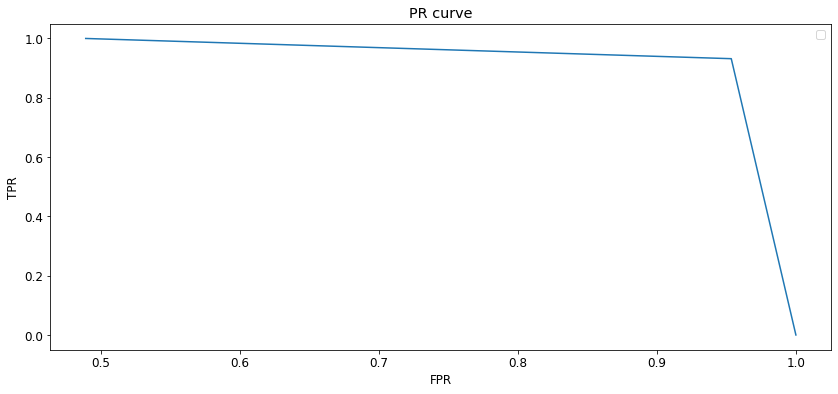

In [84]:
%matplotlib inline
evaluate_model(predictions, probs, train_predictions, train_probs)

prec,recall,_ = precision_recall_curve(y_test, predictions)
fig,ax = plt.subplots(figsize = (14,6))
ax.plot(prec,recall)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PR curve")
ax.legend();

Confusion matrix, without normalization
[[44  2]
 [ 3 41]]


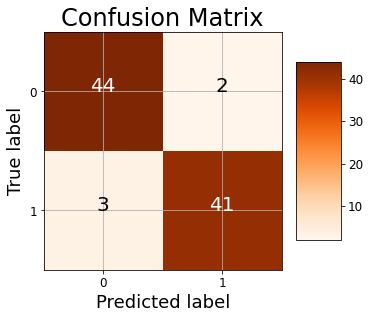

In [85]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [86]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.94      0.96      0.95        46
        True       0.95      0.93      0.94        44

    accuracy                           0.94        90
   macro avg       0.94      0.94      0.94        90
weighted avg       0.94      0.94      0.94        90



In [87]:
max_depth = [3,5,7,9,11]
max_features = [0.25,0.35,0.5,1,2]
min_samples_split = [4,8,11,15,20]
min_samples_leaf = [0.1,0.2,0.3,0.4,0.5]
max_leaf_nodes = [2,5,7,9,12]

parameters = {'max_depth': max_depth, 'max_features': max_features, 'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf, 'max_leaf_nodes': max_leaf_nodes}

In [88]:
gridSer = GridSearchCV(model, parameters) 
gridSer.fit(X_train, y_train)

best_estimator = gridSer.best_estimator_
print(gridSer.best_score_)
best_estimator

0.9142857142857143


DecisionTreeClassifier(max_depth=3, max_features=0.25, max_leaf_nodes=5,
                       min_samples_leaf=0.1, min_samples_split=4,
                       random_state=1)

Confusion matrix, without normalization
[[38  8]
 [ 3 41]]
              precision    recall  f1-score   support

       False       0.93      0.83      0.87        46
        True       0.84      0.93      0.88        44

    accuracy                           0.88        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.88      0.88      0.88        90



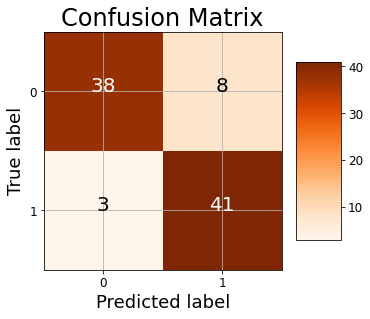

In [89]:
best_estimator.fit(X_train, y_train)
predictions = best_estimator.predict(X_test)

cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

print(classification_report(y_test, predictions))

# Conclusion

В цій лабораторній роботі було використано бібліотеку sklearn для побудови різних моделей дерева рішень. 
В якості метрик були взяті матриця неточностей (confusion matrix), точнiсть (precision), повнота (recall), мiра F1 (F1 score), а також крива точностi-повноти (precision-recall (PR) curve), ROC-
крива, показник AUC.

Для першого набору даних було побудовано три моделі. Перша модель - звичайна (без гіперпараметрів), друга (з гіперпараметрами max_depth = 15, max_features = 250, max_leaf_nodes = 100, min_samples_leaf = 12, min_samples_split = 6), третя (з гіперпараметрами max_depth = 5, max_features = 100, max_leaf_nodes = 200, min_samples_leaf = 8, min_samples_split = 4). В жодній з них не було виявлено перенавчання. Було виконано решiтчастий пошук (grid search) для пiдбору гiперпараметрiв. З запропонованих мною варіантів були підібрані такі гіперпараметри: max_depth = 13, max_features = 400, max_leaf_nodes = 100, min_samples_leaf = 4, min_samples_split = 4. На основi критерiїв якостi було вибрано найкращу модель - першу (без гіперпараметрів).

Для другого набору даних було побудовано шість моделей. Перша модель - звичайна (без гіперпараметрів), інші п'ять (по одному гіперпараметру на кожну окрему модель max_depth=3, max_features = 1, max_leaf_nodes = 7, min_samples_leaf = 8, min_samples_split = 0.3). Перенавчання можна споглядати в першій моделі. Було виконано решiтчастий пошук (grid search) для пiдбору гiперпараметрiв. З запропонованих мною варіантів були підібрані такі гіперпараметри: max_depth = 3, max_features = 0.25, max_leaf_nodes = 5, min_samples_leaf = 0.1, min_samples_split = 4. На основi критерiїв якостi було вибрано найкращу модель - шосту (з гіперпараметром max_features = 1).